# Assignment 2

In [1]:
import numpy as np
import polars as pl
from matplotlib import pyplot as plt
import seaborn as sns
import re
import nltk as nltk
import nltk.corpus  
import warnings
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import os
import wordcloud
warnings.filterwarnings("ignore")
stopwords = set(nltk.corpus.stopwords.words('english'))
wnl = nltk.WordNetLemmatizer()

### Reading the Data

In [2]:
food_inspection_pl = pl.read_csv("../data/Food_Inspections.csv")
food_inspection_pl.head()

Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
i64,str,str,i64,str,str,str,str,str,i64,str,str,str,str,f64,f64,str
2569569,"""LA BRASA RESTA...","""BRASA ROJA""",2886571,"""Restaurant""","""Risk 1 (High)""","""3556 N PULASKI...","""CHICAGO""","""IL""",60641,"""01/12/2023""","""License""","""Pass""",null,41.946271,-87.727545,"""(41.9462705509..."
2569647,"""Sauganash Elem...","""Sauganash Elem...",25211,"""School""","""Risk 1 (High)""","""6040 N Kilpatr...","""CHICAGO""","""IL""",60646,"""01/13/2023""","""Canvass""","""Pass""",null,null,null,null
2568832,"""CHECKERS""","""CHECKERS""",2808225,"""Restaurant""","""Risk 1 (High)""","""107 E 95TH ST ...","""CHICAGO""","""IL""",60619,"""12/21/2022""","""Canvass""","""Out of Busines...",null,41.721678,-87.620237,"""(41.7216784470..."
2568561,"""LA JEREZANA""","""LA JEREZANA""",27371,"""Grocery Store""","""Risk 1 (High)""","""3022 E 91ST ST...","""CHICAGO""","""IL""",60617,"""12/15/2022""","""Canvass""","""Pass""",null,41.730199,-87.550206,"""(41.7301985383..."
2568423,"""QDOBA""","""QDOBA""",2631026,"""Restaurant""","""Risk 1 (High)""","""5700 S DREXEL ...","""CHICAGO""","""IL""",60637,"""12/13/2022""","""Canvass""","""Out of Busines...",null,41.791272,-87.603887,"""(41.7912724808..."


In [3]:
type(food_inspection_pl)

polars.dataframe.frame.DataFrame

### Filtering for Failed and Passed data and removing all nans from Violations

In [3]:
failed_inspection_pl = food_inspection_pl.filter((pl.col("Results").is_in(["Fail","Pass"])) & (pl.col("Violations").is_not_null()))
failed_inspection_pl.head()

Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
i64,str,str,i64,str,str,str,str,str,i64,str,str,str,str,f64,f64,str
2555535,"""SUBWAY""","""SUBWAY""",1739186,"""Restaurant""","""Risk 1 (High)""","""100 W 87TH ST ...","""CHICAGO""","""IL""",60620,"""05/05/2022""","""Complaint""","""Fail""","""10. ADEQUATE H...",41.736374,-87.627232,"""(41.7363738202..."
2554291,"""MANA""","""MANA""",2712278,"""Grocery Store""","""Risk 2 (Medium...","""434 E 71ST ST ...","""CHICAGO""","""IL""",60619,"""04/13/2022""","""Complaint""","""Fail""","""2. CITY OF CHI...",41.765844,-87.613915,"""(41.7658442147..."
2549220,"""INTERCONTINENT...","""STARBUCKS""",2437970,"""Restaurant""","""Risk 2 (Medium...","""505 N MICHIGAN...","""CHICAGO""","""IL""",60611,"""02/01/2022""","""Canvass""","""Pass""","""32. VARIANCE O...",41.891121,-87.623989,"""(41.8911205930..."
2546641,"""RESTAURANT EL ...","""ASADOR""",2179622,"""Restaurant""","""Risk 1 (High)""","""4117 W 47TH ST...","""CHICAGO""","""IL""",60632,"""01/19/2022""","""Complaint Re-I...","""Fail""","""10. ADEQUATE H...",41.807721,-87.726825,"""(41.8077211149..."
2546273,"""SUBWAY""","""SUBWAY""",2202890,"""Restaurant""","""Risk 1 (High)""","""333 E BENTON P...","""CHICAGO""","""IL""",60601,"""01/07/2022""","""Canvass""","""Pass""","""58. ALLERGEN T...",41.88539,-87.618987,"""(41.8853900466..."


### Extracting the comment and the comments

In [92]:
def pl_extract_comments(violation_dict):
    violation = violation_dict["Violations"]
    split_violations = violation.split(sep="|")
    regex_values = []
    pattern = r"(?<= - Comments: ).*"
    for i in split_violations:
        regex = re.search(pattern,i)
        if regex is None:
            continue
        else:
            string  = i[regex.start(0):regex.end(0)].strip()
            regex_values.append(string)
    string = " ".join(regex_values)
    words = nltk.tokenize.word_tokenize(string)
    words = [word for word in words if len(word) > 1]
    words = [word for word in words if word.isalpha()]
    words = [word.lower() for word in words]
    words = [word for word in words if word != "comments"]
    words = [wnl.lemmatize(word) for word in words if word != "comments"]
    return " ".join(words) 

In [93]:
failed_inspection_pl = failed_inspection_pl.with_column(
    (
        pl.struct(["Violations"]).apply(pl_extract_comments)
    ).alias("violation_comments")
)

In [94]:
failed_inspection_pl[['violation_comments']].head(1)

violation_comments
str
"""observed no so..."


### Setting the X and Y variables

In [95]:
comments_pl = failed_inspection_pl[["violation_comments"]]
y = failed_inspection_pl[['Results']]

### Lets take a look at the most frequent words in the dataset

In [96]:
strs = comments_pl.select(pl.col("violation_comments").str.concat(" "))[0,0]
words = nltk.tokenize.word_tokenize(strs)
fdist = nltk.FreqDist(words)
fdist.most_common(30)

[('and', 849285),
 ('the', 592413),
 ('in', 557636),
 ('to', 442403),
 ('of', 332611),
 ('must', 300459),
 ('all', 266527),
 ('clean', 263759),
 ('food', 260060),
 ('area', 251558),
 ('instructed', 237334),
 ('on', 211853),
 ('at', 206512),
 ('floor', 195856),
 ('observed', 185905),
 ('be', 184628),
 ('maintain', 173884),
 ('sink', 171416),
 ('prep', 154434),
 ('not', 128116),
 ('cooler', 125411),
 ('repair', 123850),
 ('wall', 118096),
 ('storage', 113757),
 ('provide', 113209),
 ('with', 103243),
 ('for', 97382),
 ('shall', 95338),
 ('no', 94257),
 ('rear', 93816)]

As we can see, A majority of the top 30 words are stop words, so It might be wise to either use a TF-IDF vectorizer or to remove stop words. 

### Removing stopwords and making a separate dataset for testing

In [97]:
stopwords = set(nltk.corpus.stopwords.words('english'))
def pl_remove_stopwords(violation_dict):
    violation = violation_dict["violation_comments"]
    words = [word for word in violation.split(" ")]    
    words = [word for word in words if word not in stopwords]
    return " ".join(words) 

In [98]:
comments_removed_sw_pl = comments_pl.with_column(
    (
        pl.struct(["violation_comments"]).apply(pl_remove_stopwords)
    )
)

### Let's see the top 30 frequent words after stop word removal

In [99]:
strs = comments_removed_sw_pl.select(pl.col("violation_comments").str.concat(" "))[0,0]
words = nltk.tokenize.word_tokenize(strs)
fdist = nltk.FreqDist(words)
fdist.most_common(30)

[('must', 300459),
 ('clean', 263759),
 ('food', 260060),
 ('area', 251558),
 ('instructed', 237334),
 ('floor', 195856),
 ('observed', 185905),
 ('maintain', 173884),
 ('sink', 171416),
 ('prep', 154434),
 ('cooler', 125411),
 ('repair', 123850),
 ('wall', 118096),
 ('storage', 113757),
 ('provide', 113209),
 ('shall', 95338),
 ('rear', 93816),
 ('remove', 90901),
 ('equipment', 85340),
 ('violation', 79506),
 ('door', 77230),
 ('room', 70476),
 ('replace', 67729),
 ('water', 67390),
 ('ceiling', 67377),
 ('inside', 65028),
 ('ice', 58389),
 ('hand', 57143),
 ('manager', 55739),
 ('kitchen', 54211)]

### Map the target values

In [100]:
dict_map = {
    'Fail': 0,
    'Pass': 1
}
y = y.with_columns(
    pl.col("Results").map_dict(dict_map)
)

### Split the X and Y values using the train test split

In [101]:
X = comments_pl[:,0].to_numpy()
X_sw = comments_removed_sw_pl[:,0].to_numpy()
y = y[:,0].to_numpy()

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,train_size=0.7)

In [103]:
X_train_sw, X_test_sw, y_train_sw, y_test_sw = train_test_split(X_sw, y, random_state=42,train_size=0.7)

### Lets make A Simple CountVectorizer and a CountVectorizer with ngrams

In [104]:
cv = CountVectorizer()
cv.fit(X_train)

cv_sw = CountVectorizer()
cv_sw.fit(X_train_sw)

cv_ng = CountVectorizer(analyzer='word',ngram_range=(1,4))
cv_ng.fit(X_train)

CountVectorizer(ngram_range=(1, 4))

In [105]:
X_train_cv = cv.transform(X_train)
X_train_cv_sw = cv_sw.transform(X_train_sw)
X_train_cv_ng = cv_ng.transform(X_train)

In [106]:
X_test_cv = cv.transform(X_test)
X_test_cv_sw = cv_sw.transform(X_test_sw)
X_test_cv_ng = cv_ng.transform(X_test)

### Let us run a grid search on the count vectorizer to get a performant model

In [117]:
pipeline = Pipeline([
    ('clf', None),
])

parameters = [
    {
        'clf': (LogisticRegression(n_jobs=int(os.cpu_count())),),
        'clf__penalty': ('l1','l2','elasticnet'),
        'clf__C': np.arange(0.1,10.2,0.2)       
    },
    {
        'clf': (XGBClassifier(n_jobs=int(os.cpu_count())),),
        'clf__eta': np.arange(0.1,0.3,0.05),
        'clf__max_depth':np.arange(7,10,1),
    }
]
cv_gscv = GridSearchCV(pipeline, parameters,scoring='roc_auc',n_jobs=-1,verbose=10)
cv_gscv.fit(X_train_cv,y_train)
y_pred_cv = cv_gscv.predict(X_test_cv)
print(classification_report(y_test, y_pred_cv))
print(confusion_matrix(y_test,y_pred_cv))
print(cv_gscv.best_params_)

Fitting 5 folds for each of 165 candidates, totalling 825 fits
              precision    recall  f1-score   support

           0       0.99      0.96      0.97     13649
           1       0.98      0.99      0.99     29806

    accuracy                           0.98     43455
   macro avg       0.98      0.97      0.98     43455
weighted avg       0.98      0.98      0.98     43455

[[13040   609]
 [  182 29624]]
{'clf': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.20000000000000004,
              eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, 

### As we got the XGB Classifier to be the most performant classifier, lets use it with all the individual vectorized data to see which model has the best results.

#### The standard Count Vectorized data

In [108]:
cv_xgb = XGBClassifier(eta=0.2,max_depth=9,n_jobs=-1)
cv_xgb.fit(X_train_cv,y_train)
y_pred_cv = cv_xgb.predict(X_test_cv)
print(classification_report(y_test, y_pred_cv))
print(confusion_matrix(y_test,y_pred_cv))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97     13649
           1       0.98      0.99      0.99     29806

    accuracy                           0.98     43455
   macro avg       0.98      0.97      0.98     43455
weighted avg       0.98      0.98      0.98     43455

[[13040   609]
 [  182 29624]]


#### Stop Words removed

In [109]:
cv_sw_xgb = XGBClassifier(eta=0.2,max_depth=9,n_jobs=-1)
cv_sw_xgb.fit(X_train_cv_sw,y_train)
y_pred_cv_sw = cv_sw_xgb.predict(X_test_cv_sw)
print(classification_report(y_test, y_pred_cv_sw))
print(confusion_matrix(y_test,y_pred_cv_sw))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97     13649
           1       0.98      0.99      0.99     29806

    accuracy                           0.98     43455
   macro avg       0.98      0.97      0.98     43455
weighted avg       0.98      0.98      0.98     43455

[[13010   639]
 [  171 29635]]


#### With Ngrams

In [110]:
cv_ng_xgb = XGBClassifier(eta=0.2,max_depth=9,n_jobs=-1)
cv_ng_xgb.fit(X_train_cv_ng,y_train)
y_pred_cv_ng = cv_ng_xgb.predict(X_test_cv_ng)
print(classification_report(y_test, y_pred_cv_ng))
print(confusion_matrix(y_test,y_pred_cv_ng))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97     13649
           1       0.98      0.99      0.99     29806

    accuracy                           0.98     43455
   macro avg       0.98      0.98      0.98     43455
weighted avg       0.98      0.98      0.98     43455

[[13068   581]
 [  188 29618]]


### Lets make A Simple TF-IDFVectorizer and a TF-IDFVectorizer with ngrams

In [111]:
tfidfv = TfidfVectorizer()
tfidfv.fit(X_train)

tfidfv_sw = TfidfVectorizer()
tfidfv_sw.fit(X_train_sw)

tfidfv_ng = TfidfVectorizer(analyzer='word',ngram_range=(1,4))
tfidfv_ng.fit(X_train)

X_train_tfidfv = cv.transform(X_train)
X_train_tfidfv_sw = cv_sw.transform(X_train_sw)
X_train_tfidfv_ng = cv_ng.transform(X_train)

X_test_tfidfv = cv.transform(X_test)
X_test_tfidfv_sw = cv_sw.transform(X_test_sw)
X_test_tfidfv_ng = cv_ng.transform(X_test)

### Let us run a grid search on the TF-IDF vectorizer to get a performant model

In [118]:
pipeline = Pipeline([
    ('clf', None),
])

parameters = [
    {
        'clf': (LogisticRegression(n_jobs=int(os.cpu_count())),),
        'clf__penalty': ('l1','l2','elasticnet'),
        'clf__C': np.arange(0.1,10.2,0.2)       
    },
    {
        'clf': (XGBClassifier(n_jobs=int(os.cpu_count())),),
        'clf__eta': np.arange(0.1,0.3,0.05),
        'clf__max_depth':np.arange(7,10,1),
    }
]
tfidfv_gscv = GridSearchCV(pipeline, parameters,scoring='roc_auc',n_jobs=-1,verbose=10)
tfidfv_gscv.fit(X_train_tfidfv,y_train)
y_pred_tfidfv = tfidfv_gscv.predict(X_test_tfidfv)
print(classification_report(y_test, y_pred_tfidfv))
print(confusion_matrix(y_test,y_pred_tfidfv))
print(tfidfv_gscv.best_params_)

Fitting 5 folds for each of 165 candidates, totalling 825 fits
              precision    recall  f1-score   support

           0       0.99      0.96      0.97     13649
           1       0.98      0.99      0.99     29806

    accuracy                           0.98     43455
   macro avg       0.98      0.97      0.98     43455
weighted avg       0.98      0.98      0.98     43455

[[13040   609]
 [  182 29624]]
{'clf': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.20000000000000004,
              eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, 

#### The standard TF-IDF Data

In [113]:
tfidfv_xgb = XGBClassifier(eta=0.2,max_depth=9,n_jobs=-1)
tfidfv_xgb.fit(X_train_tfidfv,y_train)
y_pred_tfidfv = tfidfv_xgb.predict(X_test_tfidfv)
print(classification_report(y_test, y_pred_tfidfv))
print(confusion_matrix(y_test,y_pred_tfidfv))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97     13649
           1       0.98      0.99      0.99     29806

    accuracy                           0.98     43455
   macro avg       0.98      0.97      0.98     43455
weighted avg       0.98      0.98      0.98     43455

[[13040   609]
 [  182 29624]]


#### With Stop Words Removed

In [114]:
tfidfv_sw_xgb = XGBClassifier(eta=0.2,max_depth=9,n_jobs=-1)
tfidfv_sw_xgb.fit(X_train_tfidfv_sw,y_train)
y_pred_tfidfv_sw = tfidfv_sw_xgb.predict(X_test_tfidfv_sw)
print(classification_report(y_test, y_pred_tfidfv_sw))
print(confusion_matrix(y_test,y_pred_tfidfv_sw))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97     13649
           1       0.98      0.99      0.99     29806

    accuracy                           0.98     43455
   macro avg       0.98      0.97      0.98     43455
weighted avg       0.98      0.98      0.98     43455

[[13010   639]
 [  171 29635]]


#### With Ngrams

In [115]:
tfidfv_ng_xgb = XGBClassifier(eta=0.2,max_depth=9,n_jobs=-1)
tfidfv_ng_xgb.fit(X_train_tfidfv_ng,y_train)
y_pred_tfidfv_ng = tfidfv_ng_xgb.predict(X_test_tfidfv_ng)
print(classification_report(y_test, y_pred_tfidfv_ng))
print(confusion_matrix(y_test,y_pred_tfidfv_ng))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97     13649
           1       0.98      0.99      0.99     29806

    accuracy                           0.98     43455
   macro avg       0.98      0.98      0.98     43455
weighted avg       0.98      0.98      0.98     43455

[[13068   581]
 [  188 29618]]


Looking at all the models, and the individual runtimes, The Standard CountVectorizer or TF-IDF Vectorizer without stopwords or n-grams is the best model, as it is fast to run and also has the same accuracy.

### Let us visualize the most important words.

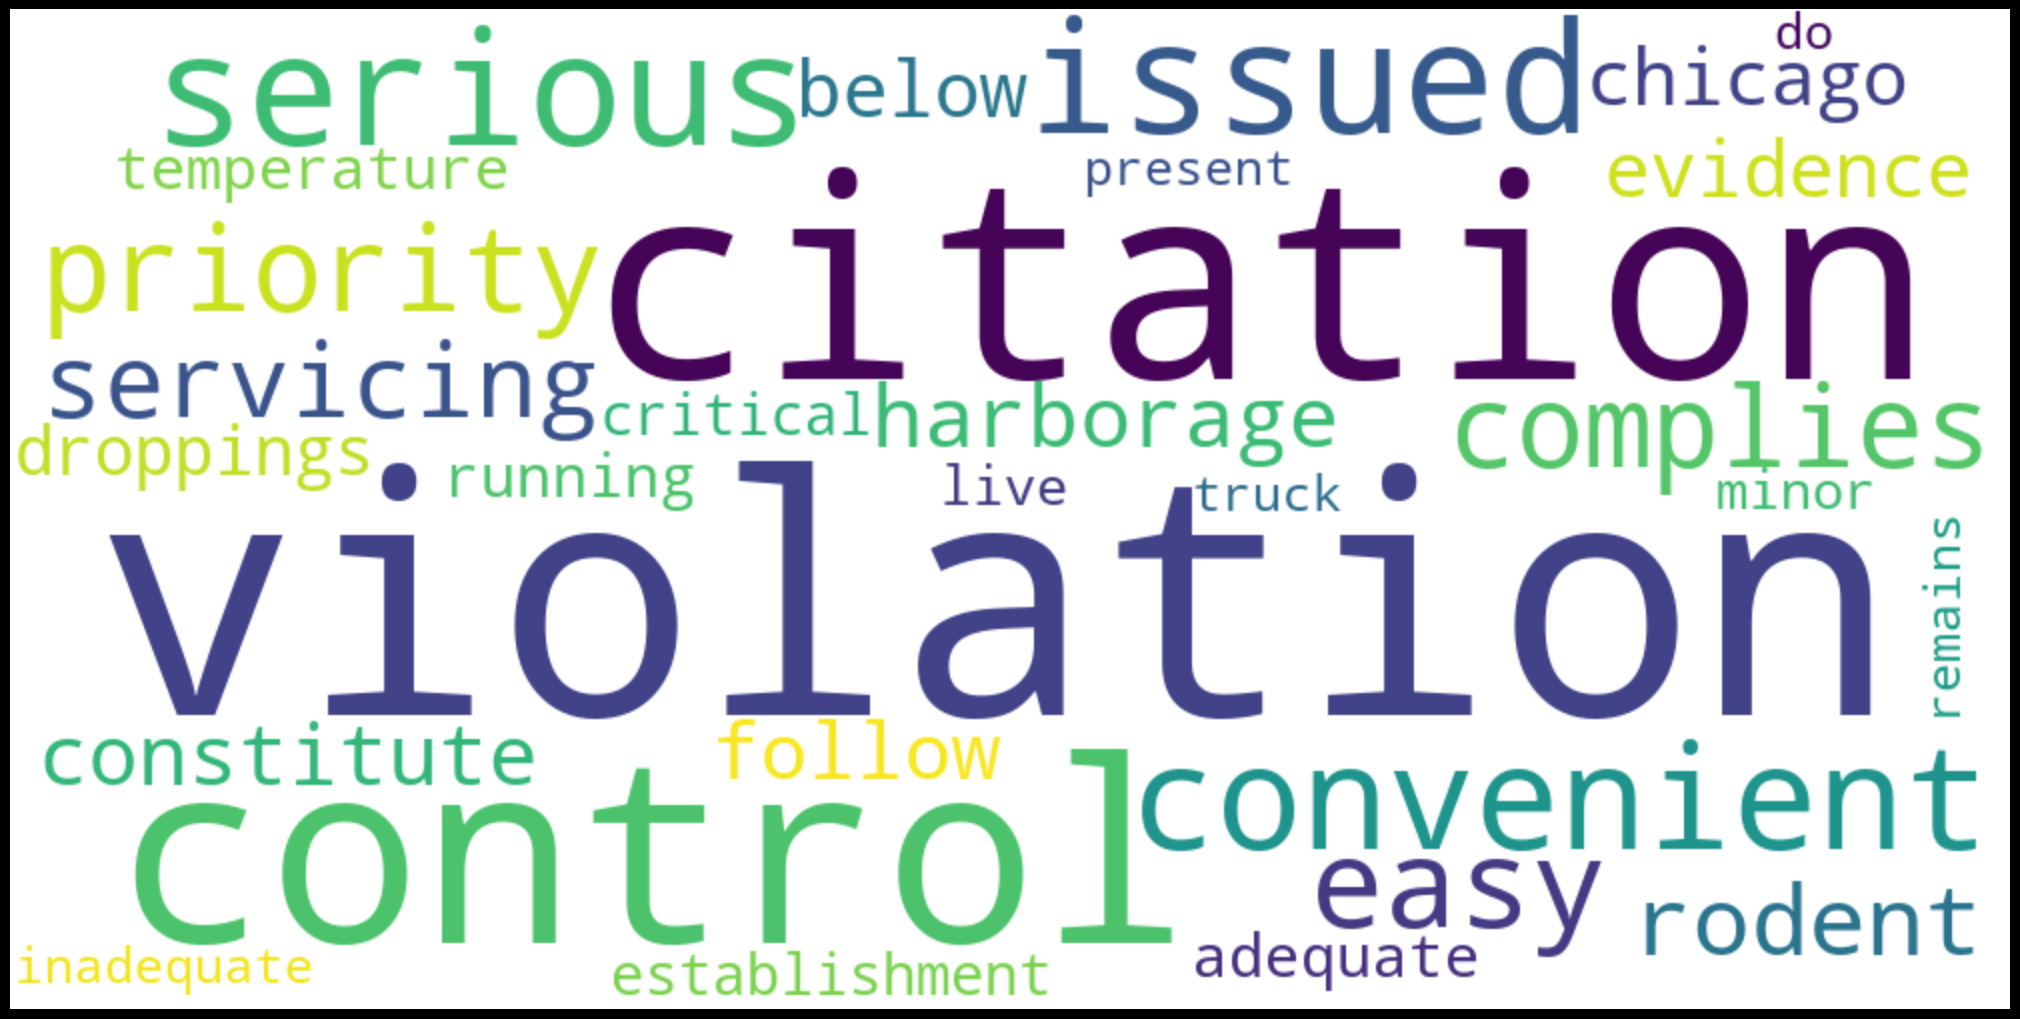

In [116]:
clf = cv_xgb



feature_names = cv.get_feature_names_out()
coefs_with_fns = zip(feature_names, clf.feature_importances_)

coefs_with_fns_df = pl.DataFrame(coefs_with_fns,
                    columns=['feature', 'coefficient'])

coefs_with_fns_df = coefs_with_fns_df.sort(by='coefficient', descending=True)
top_features_df = coefs_with_fns_df
top_features_df = top_features_df.with_columns(
    pl.col('coefficient')*(10)
    )

data = dict(zip(top_features_df['feature'].to_list(), top_features_df['coefficient'].to_list()))


wordcloud_obj = wordcloud.WordCloud(
    width = 1000,
    height = 500,
    background_color = 'white',
    max_words=30,
    stopwords = wordcloud.STOPWORDS)

wordcloud_obj.generate_from_frequencies(data)

fig = plt.figure(
    figsize = (20, 10),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud_obj, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

### To Visualize the decision tree, we would have to use graphviz, so please install it before running this.

In [ ]:
# plot_tree(model)
# plt.show()